In [2]:
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

pd.set_option('mode.chained_assignment', None)
sn.set(rc={'figure.figsize':(9,9)})
sn.set(font_scale=1.4)

## Boltzmann Machines

A Boltzmann machine is a type of stochastic recurrent neural network. It is a Markov random field (a undirected graphical model is a set of random variables that has the *Markov property* (the conditional probability distribution of future states of the process (conditional on both past and present states) depends only upon the present state, not on the sequence of events that preceded it)). They were one of the first neural networks capable of learning internal representations, and are able to represent and (given sufficient time) solve combinatoric problems.

They are named after the Boltzmann distribution in statistical mechanics, which is used in their sampling function. That's why they are called "energy based models" (EBM). They were invented in 1985 by Geoffrey Hinton, then a Professor at Carnegie Mellon University, and Terry Sejnowski, then a Professor at Johns Hopkins University.

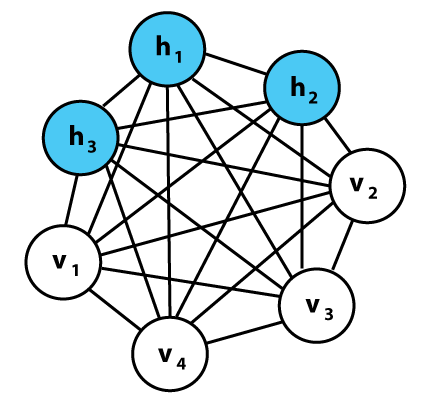

> A graphical representation of an example Boltzmann machine. Each undirected edge represents dependency. In this example there are 3 hidden units and 4 visible units. This is not a restricted Boltzmann machine.

The units in the Boltzmann machine are divided into 'visible' units, $\mathbf{v}$, and 'hidden' units, $\mathbf{h}$. The visible units are those that receive information from the 'environment', i.e. the training set is a set of binary vectors over the set $\mathbf{v}$. The distribution over the training set is denoted $P^{+}(\mathbf{v})$. Can see that all nodes form a complete graph (where all units are connected to all other units)

# Restricted Boltzmann machine

A restricted Boltzmann machine (RBM) is a generative stochastic artificial neural network that can learn a probability distribution over its set of inputs. RBMs are a variant of Boltzmann machines, with the restriction that their neurons must form a bipartite graph: a pair of nodes from each of the two groups of units (commonly referred to as the "visible" and "hidden" units respectively) may have a symmetric connection between them; and there are no connections between nodes within a group. By contrast, "unrestricted" Boltzmann machines may have connections between hidden units. This restriction allows for more efficient training algorithms than are available for the general class of Boltzmann machines, in particular the gradient-based contrastive divergence algorithm.

Restricted Boltzmann machines can also be used in deep learning networks. In particular, deep belief networks can be formed by "stacking" RBMs and optionally fine-tuning the resulting deep network with gradient descent and backpropagation.

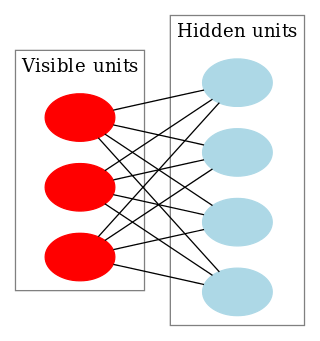

> Diagram of a restricted Boltzmann machine with three visible units and four hidden units (no bias units).


Restricted Boltzmann machines (RBM) are unsupervised nonlinear feature
learners based on a probabilistic model. The features extracted by an
RBM or a hierarchy of RBMs often give good results when fed into a
linear classifier such as a linear SVM or a perceptron.

The model makes assumptions regarding the distribution of inputs. At the
moment, scikit-learn only provides `BernoulliRBM`
, which assumes the inputs (and all units)  are either binary values or
values between 0 and 1, each encoding the probability that the specific
feature would be turned on.

The RBM tries to maximize the likelihood of the data using a particular
graphical model. The parameter learning algorithm used (`Stochastic
Maximum Likelihood`) prevents the
representations from straying far from the input data, which makes them
capture interesting regularities, but makes the model less useful for
small datasets, and usually not useful for density estimation.

The time complexity of this implementation is $O(d^2)$ assuming $d \sim n_{features} \sim n_{components}$.

The method gained popularity for initializing deep neural networks with
the weights of independent RBMs. This method is known as unsupervised
pre-training.

#### Example : RBM features for digit classification

For greyscale image data where pixel values can be interpreted as degrees of blackness on a white background, like handwritten digit recognition, the Bernoulli Restricted Boltzmann machine model (`BernoulliRBM`) can perform effective non-linear feature extraction.

In order to learn good latent representations from a small dataset, we artificially generate more labeled data by perturbing the training data with linear shifts of 1 pixel in each direction.

This example shows how to build a classification pipeline with a BernoulliRBM feature extractor and a `LogisticRegression` classifier. The hyperparameters of the entire model (learning rate, hidden layer size, regularization) were optimized by grid search, but the search is not reproduced here because of runtime constraints.

Logistic regression on raw pixel values is presented for comparison. The example shows that the features extracted by the BernoulliRBM help improve the classification accuracy.

In [25]:
from sklearn.neural_network import BernoulliRBM

X = np.array([[0.5, 0, 0], [0, 0.7, 1], [1, 0, 1], [1, 0.2, 1]])
rbm = BernoulliRBM(n_components=2)
rbm.fit(X)
print('Shape of X: {}'.format(X.shape))
X_r = rbm.transform(X)
print('Dimensionality reduced X : \n{}'.format(X_r))

Shape of X: (4, 3)
Dimensionality reduced X : 
[[0.33741478 0.33453578]
 [0.2800246  0.28145648]
 [0.29461651 0.28884148]
 [0.28217957 0.2769762 ]]


[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.39, time = 0.11s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.77, time = 0.16s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.94, time = 0.18s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.91, time = 0.16s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.69, time = 0.18s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.06, time = 0.19s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.89, time = 0.17s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.64, time = 0.16s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.36, time = 0.17s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.09, time = 0.17s
Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.92      0.94      0.93       184
           2       0.95      0.95      0.95       166
           3       0.96      0.89      0.92       19

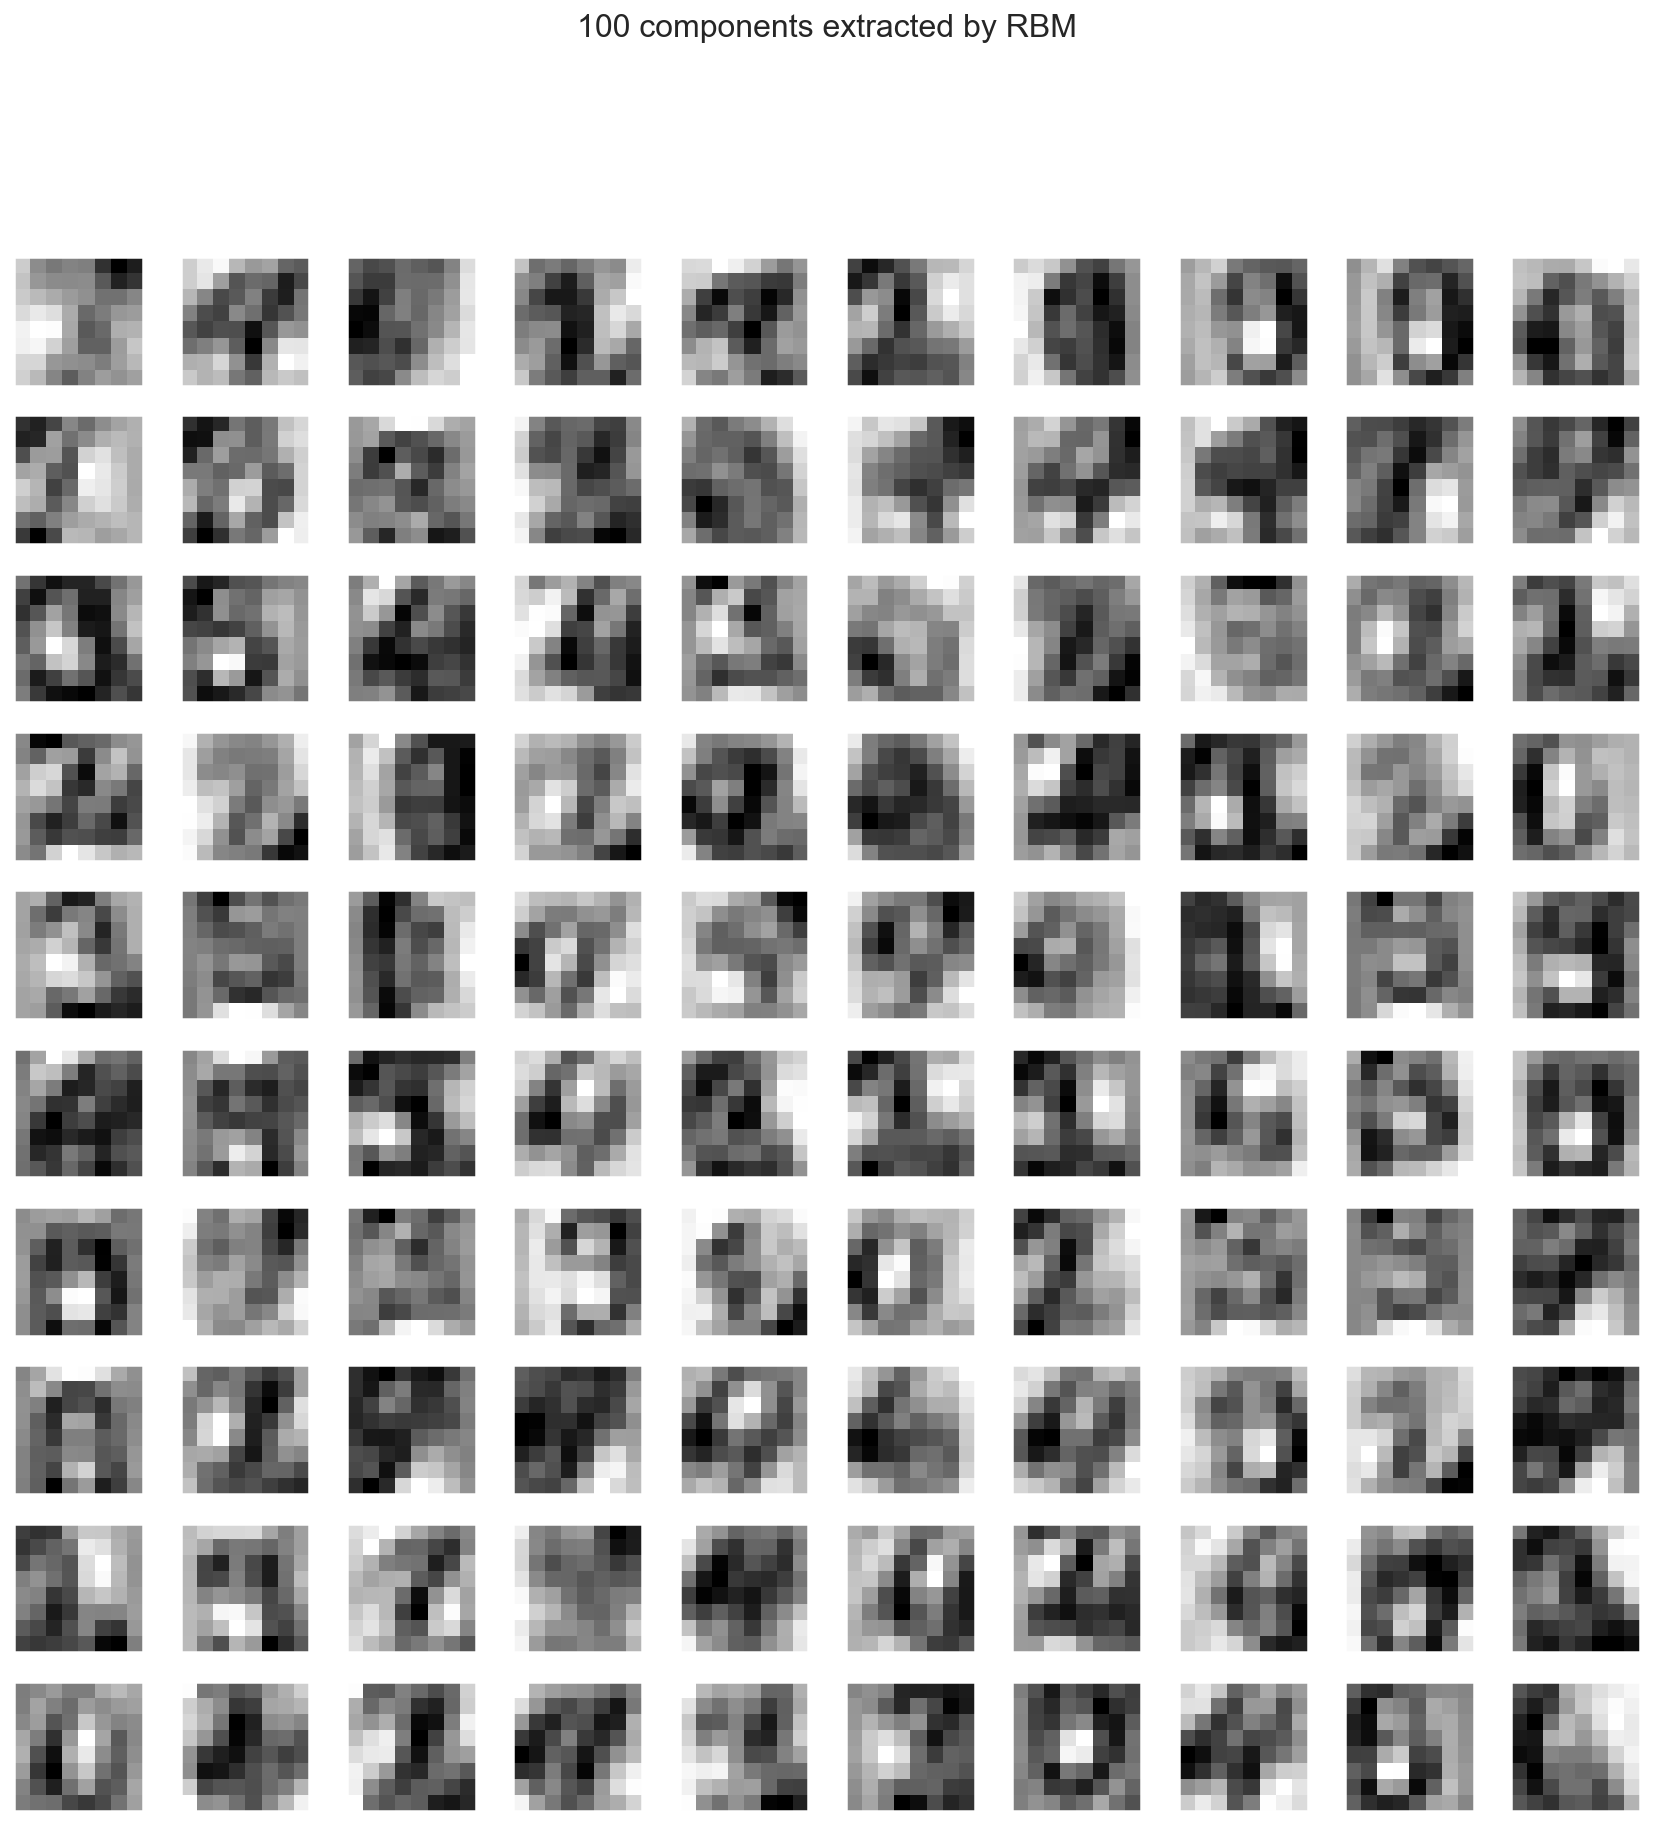

In [4]:
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.base import clone


# #############################################################################
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode='constant', weights=w).ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y


# Load Data
X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, 'float32')
X, Y = nudge_dataset(X, y)
X = (X - np.min(X, 0)) / (np.max(X, 0) + 0.0001)  # 0-1 scaling

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0)

# Models we will use
logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)

# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, Y_train)

# #############################################################################
# Evaluation

Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(Y_test, Y_pred)))

# #############################################################################
# Plotting
scale = 3.25
plt.figure(figsize=(4.2 * scale, 4 * scale))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

## Graphical model and parametrization


The graphical model of an RBM is a fully-connected bipartite graph.

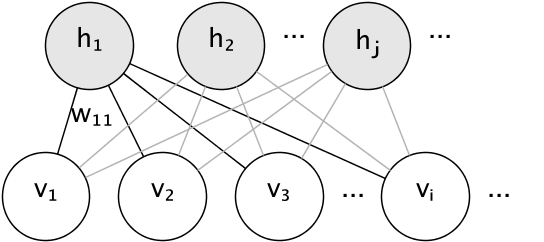

The nodes are random variables whose states depend on the state of the
other nodes they are connected to. The model is therefore parameterized
by the weights of the connections, as well as one intercept (bias) term
for each visible and hidden unit, omitted from the image for simplicity.

The energy function measures the quality of a joint assignment:

$$E(\mathbf{v}, \mathbf{h}) = -\sum_i \sum_j w_{ij}v_ih_j - \sum_i b_iv_i
  - \sum_j c_jh_j$$

In the formula above, $\mathbf{b}$ and $\mathbf{c}$ are the intercept
vectors for the visible and hidden layers, respectively. The joint
probability of the model is defined in terms of the energy:

$$P(\mathbf{v}, \mathbf{h}) = \frac{e^{-E(\mathbf{v}, \mathbf{h})}}{Z}$$

The word *restricted* refers to the bipartite structure of the model,
which prohibits direct interaction between hidden units, or between
visible units. This means that the following conditional independencies
are assumed:

$$\begin{aligned}
h_i \bot h_j | \mathbf{v} \\
v_i \bot v_j | \mathbf{h}
\end{aligned}$$

The bipartite structure allows for the use of efficient block Gibbs
sampling for inference.

### Bernoulli Restricted Boltzmann machines


In the `BernoulliRBM` , all units are
binary stochastic units. This means that the input data should either be
binary, or real-valued between 0 and 1 signifying the probability that
the visible unit would turn on or off. This is a good model for
character recognition, where the interest is on which pixels are active
and which aren\'t. For images of natural scenes it no longer fits
because of background, depth and the tendency of neighbouring pixels to
take the same values.

The conditional probability distribution of each unit is given by the
logistic sigmoid activation function of the input it receives:

$$\begin{aligned}
P(v_i=1|\mathbf{h}) = \sigma(\sum_j w_{ij}h_j + b_i) \\
P(h_i=1|\mathbf{v}) = \sigma(\sum_i w_{ij}v_i + c_j)
\end{aligned}$$

where $\sigma$ is the logistic sigmoid function:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

### Stochastic Maximum Likelihood learning

The training algorithm implemented in `BernoulliRBM`
 is known as Stochastic Maximum Likelihood (SML) or
Persistent Contrastive Divergence (PCD). Optimizing maximum likelihood
directly is infeasible because of the form of the data likelihood:

$$\log P(v) = \log \sum_h e^{-E(v, h)} - \log \sum_{x, y} e^{-E(x, y)}$$

For simplicity the equation above is written for a single training
example. The gradient with respect to the weights is formed of two terms
corresponding to the ones above. They are usually known as the positive
gradient and the negative gradient, because of their respective signs.
In this implementation, the gradients are estimated over mini-batches of
samples.

In maximizing the log-likelihood, the positive gradient makes the model
prefer hidden states that are compatible with the observed training
data. Because of the bipartite structure of RBMs, it can be computed
efficiently. The negative gradient, however, is intractable. Its goal is
to lower the energy of joint states that the model prefers, therefore
making it stay true to the data. It can be approximated by Markov chain
Monte Carlo using block Gibbs sampling by iteratively sampling each of
$v$ and $h$ given the other, until the chain mixes. Samples generated in
this way are sometimes referred as fantasy particles. This is
inefficient and it is difficult to determine whether the Markov chain
mixes.

The Contrastive Divergence method suggests to stop the chain after a
small number of iterations, $k$, usually even 1. This method is fast and
has low variance, but the samples are far from the model distribution.

Persistent Contrastive Divergence addresses this. Instead of starting a
new chain each time the gradient is needed, and performing only one
Gibbs sampling step, in PCD we keep a number of chains (fantasy
particles) that are updated $k$ Gibbs steps after each weight update.
This allows the particles to explore the space more thoroughly.
